In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st

# Consolidated Project 1
### Identifying patterns that can indicate the success of a game in the market
It is currently December 2016, and we are starting the analysis of data on computer game sales in the market from the early 1980s to the present day. The goal of the project is to identify patterns that determine the success of a game. This will allow us to focus on potentially popular products and plan advertising campaigns for 2017. It is important to remember that the data for 2016 may not be complete, and some data, such as outdated gaming platforms, may not be relevant. Sales data is broken down by regions, and we also have data on game ratings from critics and users.
### Part 1: Data Exploration and Preprocessing
Let's open the dataset and gather general information about the data.

In [2]:
data_raw = pd.read_csv('/games.csv')

First rows:

In [3]:
data_raw.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


We can already notice that not all the data is available in the dataset: there are NaN values in the columns related to ratings and age rating. It is also strange to see that the column `Year_of_Release` is represented as a decimal number instead of an integer. Let's continue the analysis:

In [4]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


That's right: we have missing values, inconsistent capitalization in column names, and inappropriate data formats in some columns for analysis.

First, let's convert the column names to snake case. We'll keep the original data in the `data_raw` variable as they may be useful later. We'll save the processed dataframe in the `data` variable.

In [5]:
data = data_raw

# Columns rename
data = data.rename(columns = 
                   {'Name' : 'name',
                   'Platform' : 'platform',
                   'Year_of_Release' : 'year_of_release',
                   'Genre' : 'genre',
                   'NA_sales' : 'na_sales',
                   'EU_sales' : 'eu_sales',
                   'JP_sales' : 'jp_sales',
                   'Other_sales' : 'other_sales',
                   'Critic_Score' : 'critic_score',
                   'User_Score' : 'user_score',
                   'Rating' : 'rating'}
                    )

Let's convert the data types of some columns to a more suitable format for analysis. We'll start with the `Year_of_Release` column. It's evident that it should be an integer value. Since we cannot convert NaN missing values to integers, it may be appropriate to simply remove those rows. The absence of data on the release year could make it difficult to analyze games over time.

However, if there are too many missing values, it could negatively impact the analysis. Therefore, let's first examine the proportion of missing values in the `year_of_release` column:

In [6]:
print(f'Year of releasse has {data["year_of_release"].isna().sum()} NaNs and the ratio of missing values is:')
print(f'{data["year_of_release"].isna().sum() / len(data):.2%}')

Year of releasse has 269 NaNs and the ratio of missing values is:
1.61%


Let's delete missing values:

In [7]:
data = data[~ (data['year_of_release'].isna())]

Now we can change the data type of the `Year_of_Release` column.

In [8]:
data['year_of_release'] = data['year_of_release'].astype('int')

The `user_score` column is currently of string type, but for analysis purposes, it is critical to have it as a numeric (floating-point) type. Let's take a closer look at the column:

In [9]:
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In addition to empty strings, which will not hinder the conversion of the column to a numeric format, the data contains the string "tbd," which stands for "to be declared," indicating that there is no information available at the moment. Could this value be assigned systematically rather than randomly? My assumption is that it only appears for new games where the information has not been filled in yet. Let's verify this:

In [10]:
data[data['user_score'] == 'tbd'].describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score
count,2376.000000,2376.000000,2376.000000,2376.000000,2376.000000,1056.000000
mean,2007.450337,0.125539,0.043674,0.002782,0.015905,60.766098
std,3.484229,0.176593,0.112068,0.026395,0.039411,11.190603
min,1997.000000,0.000000,0.000000,0.000000,0.000000,23.000000
25%,2005.000000,0.030000,0.000000,0.000000,0.000000,54.000000
50%,2008.000000,0.070000,0.010000,0.000000,0.010000,62.000000
75%,2010.000000,0.150000,0.040000,0.000000,0.020000,69.000000
max,2016.000000,3.450000,2.590000,0.860000,1.090000,90.000000


My assumption turned out to be incorrect: the game years range from 1997 to 2016. In that case, let's empty these cells: we'll convert them to NaN values, and then change the data type of the column to float.

In [11]:
data['user_score'] = data['user_score'].replace('tbd', np.NaN)
data['user_score'] = data['user_score'].astype('float')

Let's take another look at the data types:

In [12]:
data.dtypes

name                object
platform            object
year_of_release      int32
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score         float64
rating              object
dtype: object

Everything looks fine. Let's move on to working with missing values:

In [13]:
data.isna().sum()

name                  2
platform              0
year_of_release       0
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8463
user_score         8983
rating             6678
dtype: int64

We can simply remove the rows with missing data in the game title and genre since it's only two rows in the dataset.

In [14]:
data = data[(~data['name'].isna()) & (~data['genre'].isna())]

Deleting missing values in the critic/user scores and age rating columns is risky as it would result in losing a significant amount of data. Could we try filling them with appropriate values? For example, the scores could be filled with the mean or median values based on region/platform.

My response: __No__. There is no data suggesting that games are rated similarly in any specific region or based on the game genre. It is possible that ratings from critics and gamers may be influenced by these factors, but the gameplay features of each individual game primarily influence the ratings.

Solution: Leave the missing values in the scores untouched.

Let's check how much our dataset has changed after removing the missing data:

In [15]:
# Compare the sizes of the original and preprocessed data
print(f"The dataset has reduced by only {1 - data.shape[0] / data_raw.shape[0]:.2%}")

The dataset has reduced by only 1.62%


What should we do with the age rating? Let's fill the missing values in this column with a placeholder value of "No Data"

In [16]:
data['rating'] = data['rating'].fillna('no_info')

Let's add a column called "Total Sales" that includes the total number of copies sold worldwide. We'll also take a look at sales broken down by platforms/regions and genres/regions. We'll save these pivot tables in variables `sales_platforms` and `sales_genres`, respectively. I'm sure they will be useful later on.

In [17]:
data['worldwide_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

# Aggregate data by regions and genres
sales_platforms = data.pivot_table(index = 'platform', values = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'worldwide_sales'], aggfunc = 'sum')
sales_genres = data.pivot_table(index = 'genre', values = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'worldwide_sales'], aggfunc = 'sum')

# View sales by platforms and genres, sorted by total sales in descending order
display(sales_platforms.sort_values(by = 'worldwide_sales', ascending = False))
display(sales_genres.sort_values(by = 'worldwide_sales', ascending = False))

,eu_sales,jp_sales,na_sales,other_sales,worldwide_sales
platform,,,,,
PS2,332.63,137.54,572.92,190.47,1233.56
X360,268.32,12.30,595.74,84.88,961.24
PS3,327.21,79.41,390.13,134.59,931.34
Wii,258.32,68.28,486.87,77.71,891.18
DS,188.41,175.02,380.31,59.04,802.78
PS,212.39,139.78,334.72,40.69,727.58
PS4,141.09,15.96,108.74,48.35,314.14
GBA,74.59,46.56,184.12,7.61,312.88
PSP,65.62,75.88,107.27,40.76,289.53


,eu_sales,jp_sales,na_sales,other_sales,worldwide_sales
genre,,,,,
Action,510.99,160.14,863.17,182.22,1716.52
Sports,371.33,134.93,671.20,132.21,1309.67
Shooter,314.52,38.68,584.83,103.33,1041.36
Role-Playing,188.24,353.39,330.04,59.41,931.08
Platform,199.39,130.71,444.44,51.01,825.55
Misc,210.60,107.02,399.57,73.10,790.29
Racing,234.49,56.63,356.86,75.51,723.49
Fighting,99.00,87.28,220.51,35.87,442.66
Simulation,113.35,63.64,180.40,30.57,387.96


I can now start drawing initial conclusions about the popularity of certain genres and gaming platforms. Let's proceed to exploratory data analysis (EDA) to gain further insights from the data.

### Part 2: Exploratory Data Analysis
Let's start by examining the number of games released in different years. It's possible that not all years are relevant for planning in 2017.

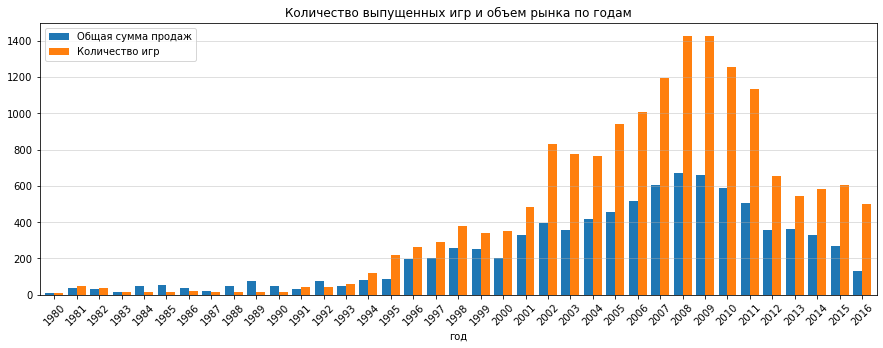

In [18]:
# Create two pivot tables: the number of games released by year and the total sales by year.
sales_per_year = data.pivot_table(index = 'year_of_release', values = 'worldwide_sales', aggfunc = 'sum')
games_per_year = data.pivot_table(index = 'year_of_release', values = 'name', aggfunc = 'count')

# Combine both tables using the "Year_of_Release" as the index.
games_and_sales_per_year = sales_per_year.join(games_per_year)

# View the distribution of games released by year.
games_and_sales_per_year.plot(kind = 'bar', figsize = (15, 5), xlabel = 'год', legend = True, width = .8)
plt.title('Количество выпущенных игр и объем рынка по годам')
plt.legend(['Общая сумма продаж', 'Количество игр'], loc = 2)
plt.xticks(rotation=45)
plt.grid(alpha = .5, axis = 'y')
plt.show()

The computer game market steadily grew until 2009, after which there was a slight decline. However, in 2012, a significant turning point occurred: the number of games released dropped by more than half, and the number of copies sold decreased by a third compared to the peak year of 2009.

I couldn't find any information on major industry shifts during that year. Nevertheless, the numbers indicate that it doesn't make sense to base decision-making on data before 2012, as the market has changed.

Moving forward with further analysis, we will consider 2012 and later years. Let's update the previously created pivot tables, `sales_platforms` and `sales_genres`, according to the discovered information.

In [19]:
sales_platforms = data.query('year_of_release > 2011')\
.pivot_table(index = 'platform', values = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'worldwide_sales'], aggfunc = 'sum')

sales_genres = data.query('year_of_release > 2011')\
.pivot_table(index = 'genre', values = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'worldwide_sales'], aggfunc = 'sum')

Now let's take a look at the current gaming platforms and the lifespan of each platform. To build a timeline of emerging and declining platforms, we can add the median release year of games for each platform. This will help us understand the approximate duration of each platform's existence.

In [20]:
median_release_year = pd.DataFrame(data.groupby('platform')['year_of_release'].median())\
.rename(columns = {'year_of_release' : 'median_year_of_release'})

median_release_year['median_year_of_release'] = median_release_year['median_year_of_release'].astype('int')

data = data.merge(median_release_year, on = 'platform', how = 'left')

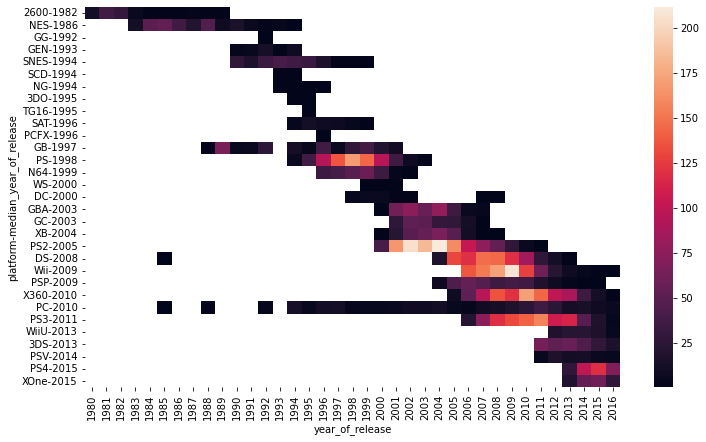

In [21]:
plt.figure(figsize = (12,7))
sns.heatmap(data.pivot_table(index = ['platform', 'median_year_of_release'], values = 'worldwide_sales', columns = 'year_of_release', aggfunc = 'sum').sort_values(by = 'median_year_of_release'))

plt.show()

In the heatmap, we can already see some outliers in the data. For example, there are games sold for Nintendo DS in 1985, even though the platform was only introduced in 2004.

We can also observe that the concentration of platforms has increased in recent years. In 1996, games were sold for only eight platforms, while in 2013, there were already eleven platforms. We can also approximate the lifespan of each platform: in the 1990s, platforms were born and ceased to exist within 3-6 years (with the exception of the legendary SNES - Super Nintendo Entertainment System). In recent years, platforms have had longer lifespans, and the lower steps of the ladder have become longer. For example, the PS3 has been in existence for 10 years.

And, of course, there is a long tail extending from the heatmap, representing the enduring gaming platform - PC, which has been around for ages.

Now let's calculate the average lifespan of each platform. We'll save the data in a variable named `platform_lifetime`.

In [22]:
platform_lifetime = data[data['platform'] != 'PC'].groupby('platform')\
.agg(first_game = ('year_of_release', 'min'), last_game = ('year_of_release', 'max'))

platform_lifetime['lifetime'] = platform_lifetime['last_game'] - platform_lifetime['first_game']

print(f'Mean platform lifetime: {round(platform_lifetime["lifetime"].mean(), 2)} years')

Mean platform lifetime: 6.83 years


We'll keep in mind that the heatmap demonstrated that the lifespan of platforms tends to increase in recent years.

Now let's determine the most popular platforms in recent years. Since sales_platforms contains data from 2012 onwards, we can use that to identify the top platforms.

In [23]:
# Most popular platforms
sales_platforms['worldwide_sales'].describe()

count     11.000000
mean     131.502727
std      112.116322
min       11.190000
25%       42.275000
50%       82.190000
75%      215.575000
max      314.140000
Name: worldwide_sales, dtype: float64

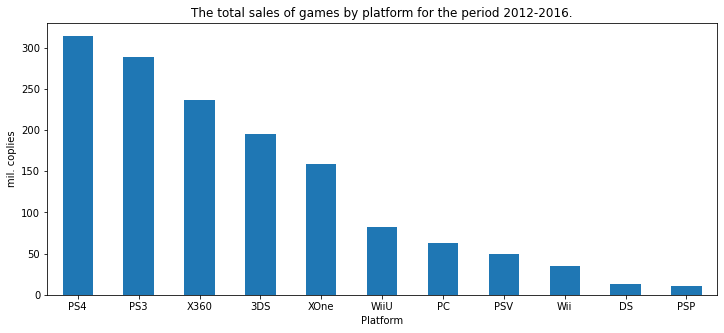

In [24]:
sales_platforms.sort_values(by = 'worldwide_sales', ascending = False)\
.plot(y = 'worldwide_sales', kind = 'bar', figsize = (12, 5), xlabel = 'Platform', ylabel = 'mil. coplies', legend = False)
plt.title('The total sales of games by platform for the period 2012-2016.')
plt.xticks(rotation=0)
plt.show()

I assume that a platform can be considered "popular" if it falls at least in the second quartile in terms of copies sold in recent years.

Let's create a list of popular platforms and save it in a variable called `modern_popular_platforms`. We'll filter the list based on the 'worldwide_sales' column to include only the popular platforms from the second to fourth quartiles of total global sales.

In [25]:
modern_popular_platforms = []

for plat in sales_platforms[sales_platforms['worldwide_sales'] > 43].index.unique():
    modern_popular_platforms.append(plat)

print('Popular platforms:')    
print(modern_popular_platforms)

Popular platforms:
['3DS', 'PC', 'PS3', 'PS4', 'PSV', 'WiiU', 'X360', 'XOne']


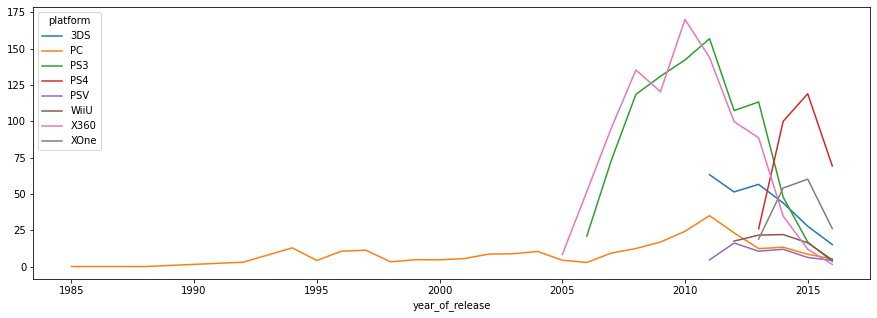

In [26]:
data[data['platform'].isin(modern_popular_platforms)]\
.pivot_table(index='year_of_release', columns = 'platform', values='worldwide_sales', aggfunc='sum')\
.plot(figsize = (15, 5))
plt.show()

It's evident that currently, the popular platforms are those that have emerged relatively recently. Among the long-lasting platforms, we can highlight the __Xbox 360__ and __PS3__. And, of course, the personal computer (PC) remains a popular platform.

Now it's time to update the main dataset based on our findings about the turning point in 2012.

In [27]:
data = data.query('year_of_release > 2011')

Let's take a closer look at the sales data for the popular platforms, keeping in mind that the data for 2016 may be incomplete. We won't remove the year 2016 from the dataset, but we won't include it in the plotted graph to avoid confusing the viewer with potentially incomplete data.

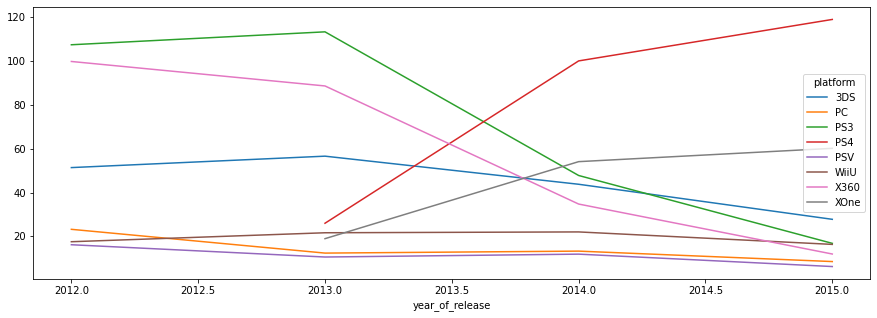

In [28]:
data[data['platform'].isin(modern_popular_platforms) & (data['year_of_release'] < 2016)]\
.pivot_table(index='year_of_release', columns = 'platform', values='worldwide_sales', aggfunc='sum')\
.plot(figsize = (15, 5))
plt.show()

It's interesting to note that only two platforms, Xbox One and PS4, show growth. This is intriguing considering that Xbox One ranks fifth in terms of the number of copies sold for the recent years among the list of "popular platforms." It seems that this young platform deserves closer attention.

Let's create a box plot to visualize the distribution of global game sales across different platforms. To do this, I'll use a loop:

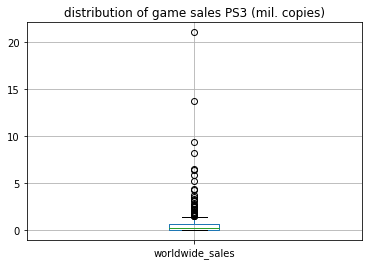

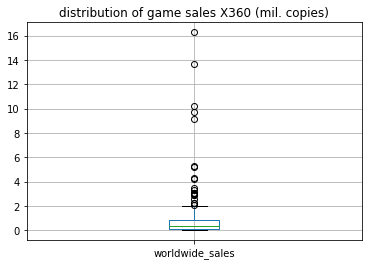

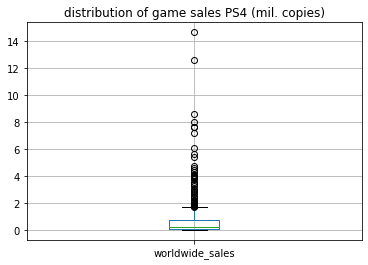

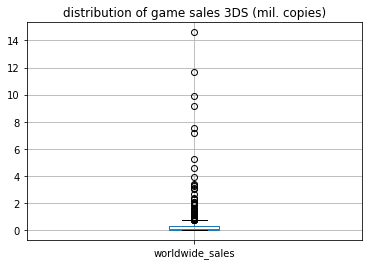

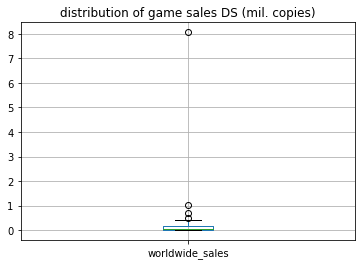

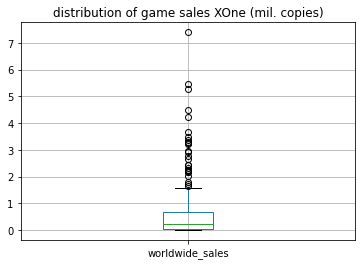

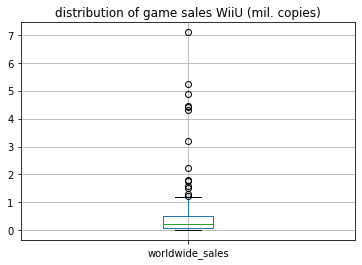

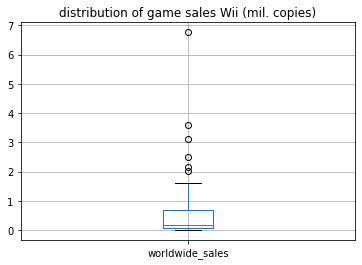

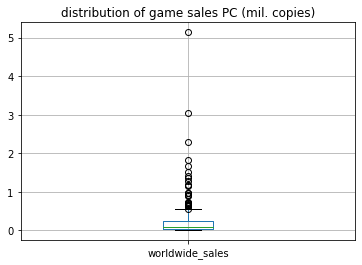

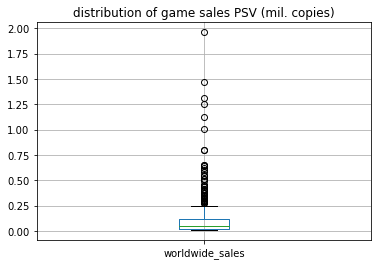

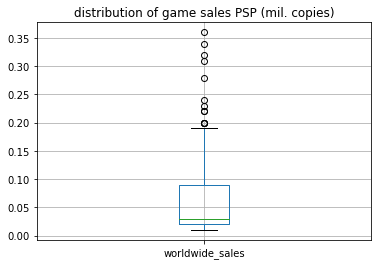

In [29]:
for plat in data['platform'].unique():
    data[data['platform'] == plat].boxplot('worldwide_sales')
    plt.title(f'distribution of game sales {plat} (mil. copies)')
    plt.show()

The graphs indeed show a significant variation in the data across all platforms, except for PSP. However, I wouldn't rush to label these as anomalies or data errors. It seems that for each platform, there are "hits" or top-selling games that significantly stand out in terms of copies sold.

The "three sigma rule" states that 99% of a normally distributed sample falls within plus or minus three standard deviations from the population mean. While I'm not certain whether global sales follow a normal distribution, I can try setting the y-axis limit to the mean plus one standard deviation. This way, we can focus more on the box itself and not just the outliers.

Let's adjust the y-axis limit to better observe the box and its distribution, rather than just the outliers.

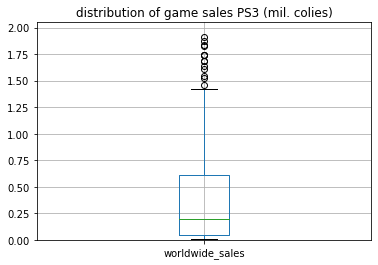

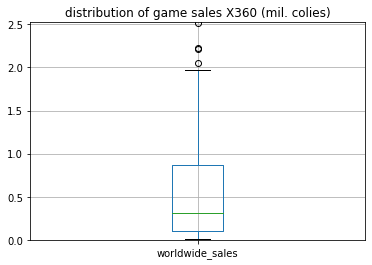

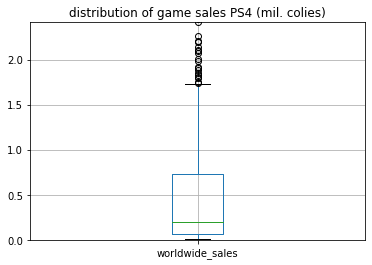

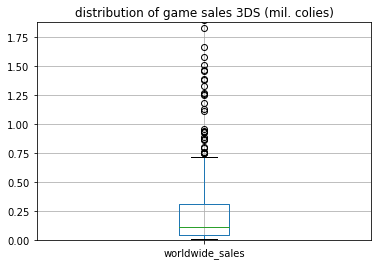

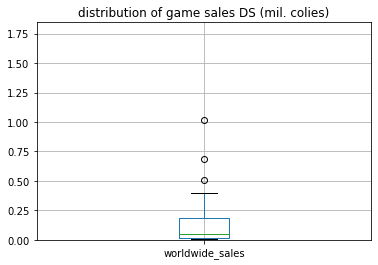

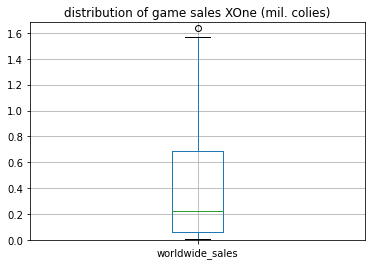

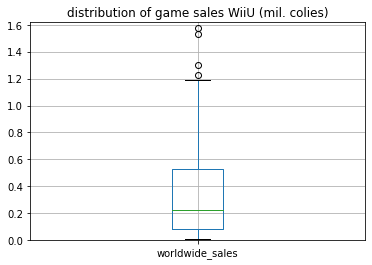

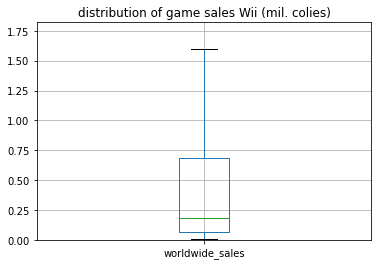

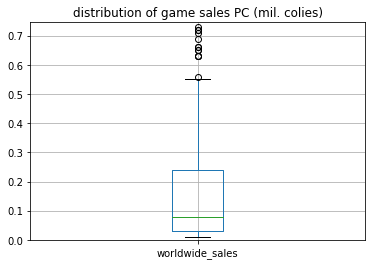

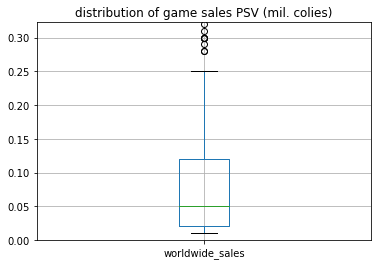

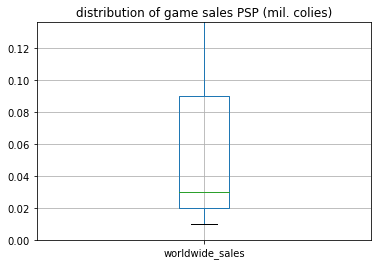

In [30]:
for plat in data['platform'].unique():
    data[data['platform'] == plat].boxplot('worldwide_sales')
    plt.title(f'distribution of game sales {plat} (mil. colies)')
    
    plt.ylim(0, (data[data['platform'] == plat]['worldwide_sales'].mean() + data[data['platform'] == plat]['worldwide_sales'].std()))
    plt.show()

In [31]:
for plat in modern_popular_platforms:
    print('Most popular game on platform', plat)
    print(pd.Series.to_string(data[data["platform"] == plat].query("worldwide_sales == worldwide_sales.max()")['name'], index = False))
    print('')

Most popular game on platform 3DS
Pokemon X/Pokemon Y

Most popular game on platform PC
Diablo III

Most popular game on platform PS3
Grand Theft Auto V

Most popular game on platform PS4
Call of Duty: Black Ops 3

Most popular game on platform PSV
Minecraft

Most popular game on platform WiiU
Mario Kart 8

Most popular game on platform X360
Grand Theft Auto V

Most popular game on platform XOne
Call of Duty: Black Ops 3



As expected, those are very popular games that are well-known even to those who are relatively distant from the gaming industry, such as GTA, Diablo, Call of Duty, Pokemon, and Minecraft. Let's consider that there are no anomalies in the data.

Now let's examine how user and critic reviews influence sales within a popular platform. We'll create a scatter plot matrix and calculate the correlation between the ratings and sales. For example, let's take Xbox One, if only because I happen to own that console.

,critic_score,user_score,worldwide_sales
critic_score,1.000000,0.472462,0.416998
user_score,0.472462,1.000000,-0.068925
worldwide_sales,0.416998,-0.068925,1.000000


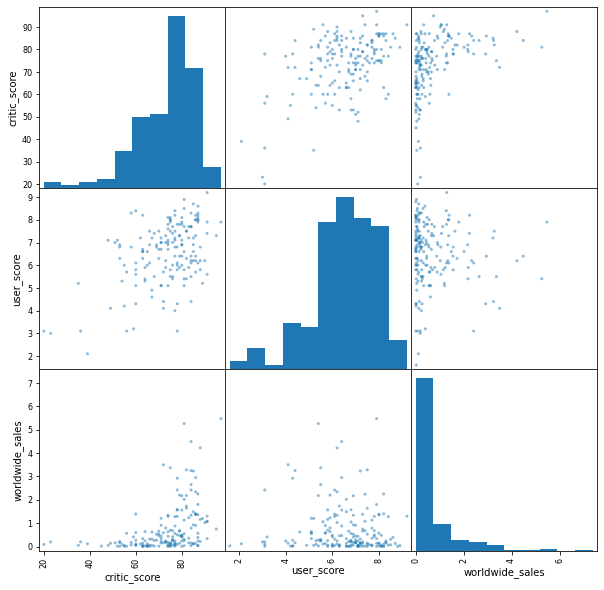

In [32]:
display(data[data['platform'] == 'XOne'][['critic_score', 'user_score', 'worldwide_sales']].corr())

pd.plotting.scatter_matrix(data[data['platform'] == 'XOne'][['critic_score', 'user_score', 'worldwide_sales']]\
, figsize = (10, 10))
plt.show()

To be honest, I'm surprised. While there seems to be some correlation between critic and user ratings, albeit not very strong, it appears that they have little to no impact on sales. The only exception might be games with high ratings from critics, which have a slightly higher chance of being commercially successful.

Could it be that Xbox is an unusual platform? Just to validate my conclusions, let's take a look at PlayStation as well.

,critic_score,user_score,worldwide_sales
critic_score,1.000000,0.557654,0.406568
user_score,0.557654,1.000000,-0.031957
worldwide_sales,0.406568,-0.031957,1.000000


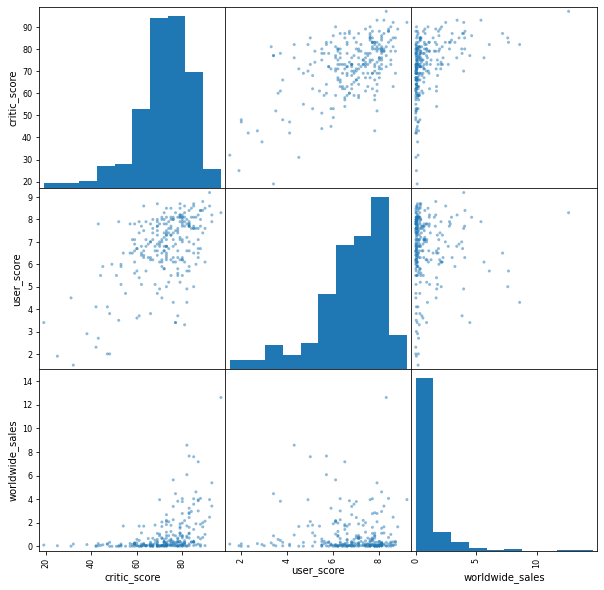

In [33]:
display(data[data['platform'] == 'PS4'][['critic_score', 'user_score', 'worldwide_sales']].corr())

pd.plotting.scatter_matrix(data[data['platform'] == 'PS4'][['critic_score', 'user_score', 'worldwide_sales']]\
, figsize = (10, 10))
plt.show()

It's still the same. There appears to be even a slight negative correlation between user ratings and game success.

To completely dispel any doubts, let's create a pivot table to summarize these correlations for all popular platforms. I'll use a loop and three lists: platform name, critic-sales correlation, and user-sales correlation.

The loop will populate these lists with the data, and then I'll combine them into a table for visualization.

,platform,critics_sales_corr,users_sales_corr
0,3DS,0.320803,0.197583
1,PC,0.237243,-0.121867
2,PS3,0.331497,-0.005144
3,PS4,0.406568,-0.031957
4,PSV,0.094488,-0.004339
5,WiiU,0.348380,0.400219
6,X360,0.360573,0.006164
7,XOne,0.416998,-0.068925


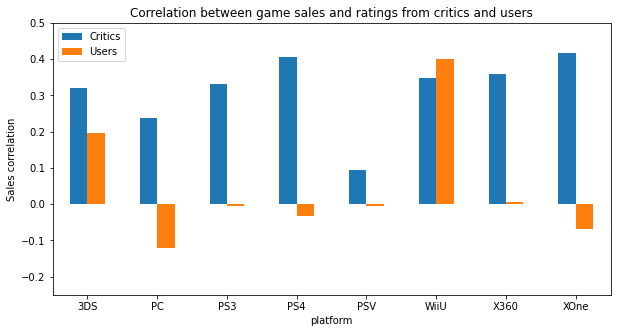

In [34]:
plat_list = []
user_score_corr_list = []
critic_score_corr_list = []

for plat in modern_popular_platforms:
    plat_list.append(plat)
    user_score_corr_list.append(data[data['platform'] == plat]['user_score']\
                                .corr(data[data['platform'] == plat]['worldwide_sales']))
    critic_score_corr_list.append(data[data['platform'] == plat]['critic_score']\
                                  .corr(data[data['platform'] == plat]['worldwide_sales']))

super_corr = pd.DataFrame({'platform' : plat_list, 'critics_sales_corr' : critic_score_corr_list, 'users_sales_corr' : user_score_corr_list})

display(super_corr)

super_corr.plot(kind = 'bar', x = 'platform', figsize = (10, 5), width = .5, ylim = (-.25, .5), ylabel = 'Sales correlation')
plt.title('Correlation between game sales and ratings from critics and users')
plt.legend(('Critics', 'Users'))
plt.xticks(rotation = 0)
plt.show()

It has become clear that when planning sales, user reviews can be completely disregarded. Critics have slightly more weight in making such decisions.

### Part 3. Creating a profile of users in each region

Now let's take a look at the popularity of different genres across different regions. We'll once again use a heatmap and the previously prepared pivot table `sales_genres`.

Mean sales:


,eu_sales,jp_sales,na_sales,other_sales,worldwide_sales
genre,,,,,
Shooter,0.482851,0.039277,0.616043,0.158553,1.296723
Platform,0.251882,0.101529,0.298588,0.065647,0.717647
Sports,0.257799,0.029888,0.304216,0.083731,0.675634
Role-Playing,0.131162,0.176865,0.172973,0.040081,0.521081
Racing,0.237304,0.021739,0.149739,0.056435,0.465217
Misc,0.137083,0.066979,0.198906,0.039948,0.442917
Simulation,0.181875,0.130125,0.099625,0.027375,0.439000
Action,0.154549,0.051212,0.172493,0.049602,0.427856
Fighting,0.098991,0.086606,0.181560,0.041009,0.408165


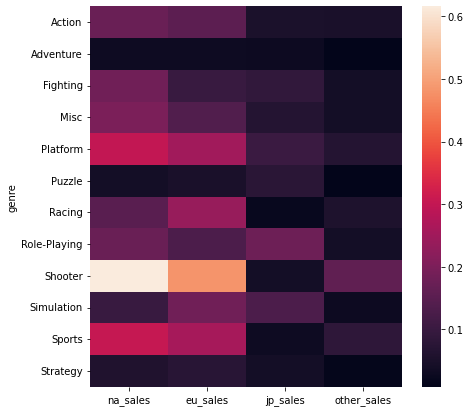

Median sales:


,eu_sales,jp_sales,na_sales,other_sales,worldwide_sales
genre,,,,,
Shooter,0.170,0.00,0.20,0.05,0.440
Sports,0.050,0.00,0.08,0.02,0.240
Platform,0.080,0.00,0.09,0.02,0.210
Role-Playing,0.010,0.06,0.02,0.01,0.140
Racing,0.090,0.00,0.04,0.02,0.140
Fighting,0.020,0.03,0.05,0.01,0.130
Action,0.020,0.01,0.02,0.01,0.120
Misc,0.015,0.02,0.01,0.00,0.120
Simulation,0.030,0.00,0.00,0.01,0.120


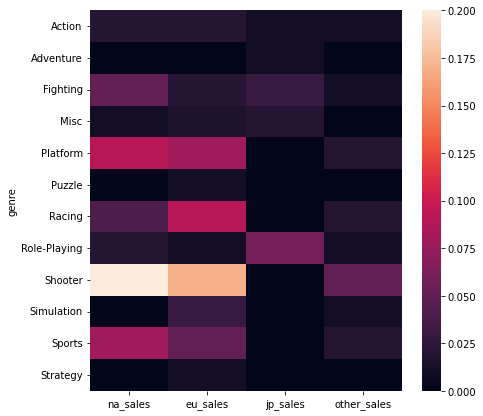

In [35]:
genres_table_mean = data.pivot_table(index = 'genre', values = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'worldwide_sales'], aggfunc = 'mean')
genres_table_median = data.pivot_table(index = 'genre', values = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'worldwide_sales'], aggfunc = 'median')

print('Mean sales:')
display(genres_table_mean.sort_values(by = 'worldwide_sales', ascending = False))
plt.figure(figsize = (7, 7))
sns.heatmap(genres_table_mean[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']])
plt.show()
print('Median sales:')
display(genres_table_median.sort_values(by = 'worldwide_sales', ascending = False))
plt.figure(figsize = (7, 7))
sns.heatmap(genres_table_median[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']])
plt.show()

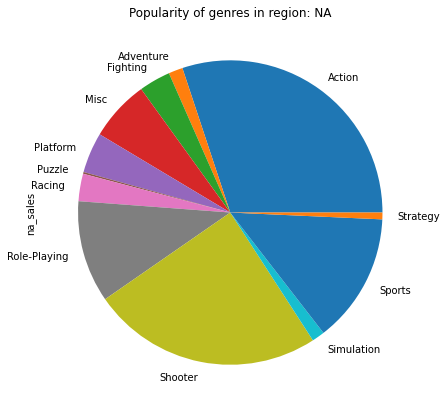

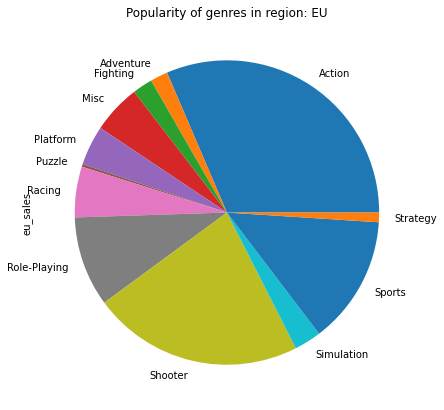

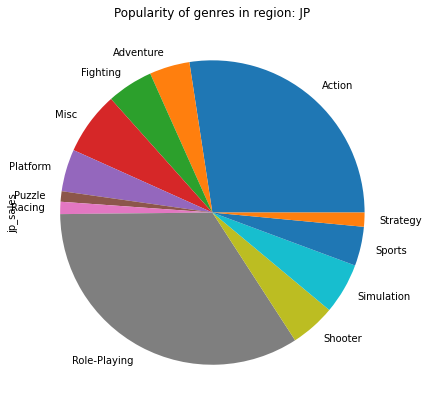

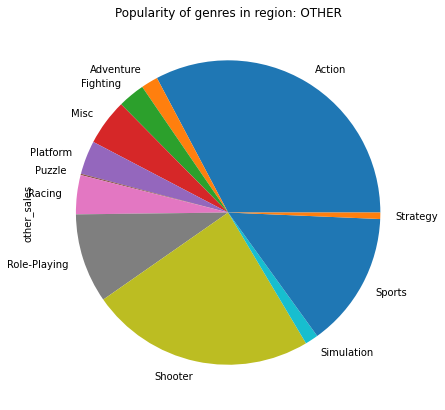

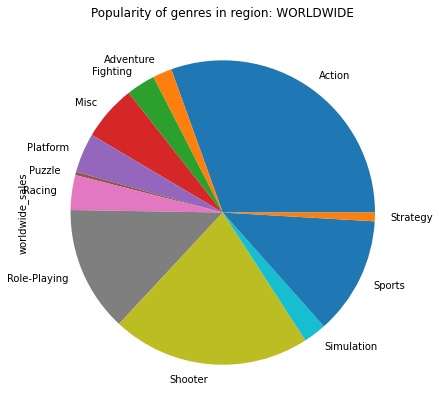

In [36]:

region_list = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'worldwide_sales']

for i in region_list:
    sales_genres.plot(kind = 'pie', y = i, figsize = (7, 7), legend = False, )
    plt.title(f'Popularity of genres in region: {i.replace("_sales", "").upper()}', loc='center')
    plt.show()

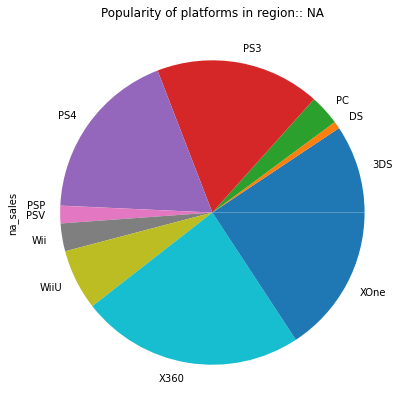

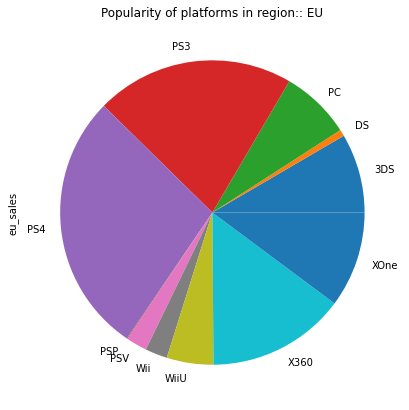

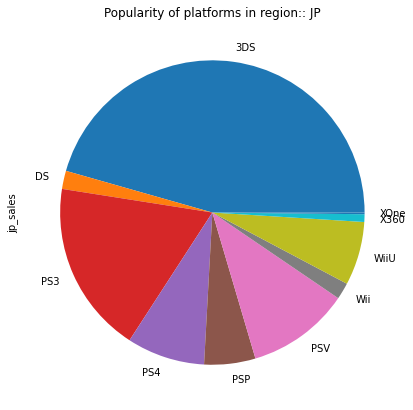

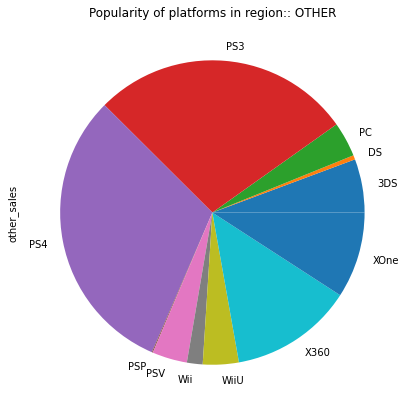

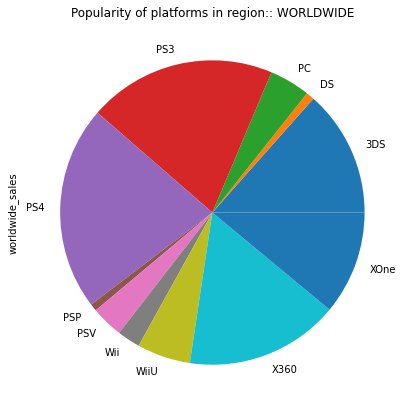

In [37]:
region_list = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'worldwide_sales']

for i in region_list:
    sales_platforms.plot(kind = 'pie', y = i, figsize = (7, 7), legend = False, )
    plt.title(f'Popularity of platforms in region:: {i.replace("_sales", "").upper()}', loc='center')
    plt.show()

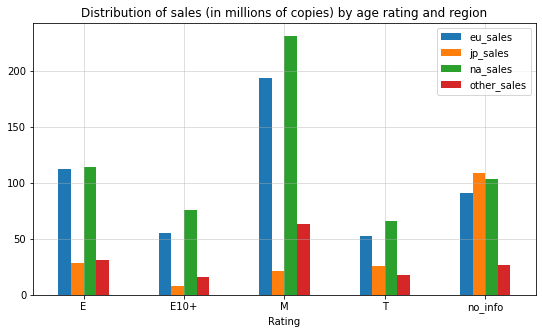

In [38]:
data.pivot_table(index = 'rating', values = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales'], aggfunc = 'sum')\
.plot(kind = 'bar', figsize = (9, 5), grid = True, xlabel = 'Rating')
plt.title('Distribution of sales (in millions of copies) by age rating and region')
plt.xticks(rotation=0)
plt.grid(alpha = .5)
plt.show()

It's evident that in Europe and the US, games are primarily entertainment for adults.

Japan stands out in this regard - a large portion of the sold games have an "everyone" age rating. However, it's important not to rely too heavily on these data as there are many missing values that can affect further decisions.

Do game sales correlate across different regions? I have a feeling that I already know the answer to this question. We have already seen numerous data points indicating that all users behave similarly, except for Japanese users. Nevertheless, let's verify this.

In [39]:
data[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].corr()

,na_sales,eu_sales,jp_sales,other_sales
na_sales,1.000000,0.767484,0.271010,0.792277
eu_sales,0.767484,1.000000,0.265134,0.936906
jp_sales,0.271010,0.265134,1.000000,0.203078
other_sales,0.792277,0.936906,0.203078,1.000000


As expected, a game that sells well in Europe is likely to sell well in the US (or vice versa), but it may not necessarily sell well in Japan.

Now it's time to test some hypotheses. To conduct the tests, I'll use the `data_raw` dataset to ensure an adequate sample size without being restricted by the year.

Let's formulate the null hypothesis H<sub>0</sub>:
The average user ratings of the Xbox One and PC platforms are the same. In other words,

_The population mean of "user ratings for Xbox One platform" = the population mean of "user ratings for PC platform"_

Let's formulate the alternative hypothesis H<sub>1</sub>:

_The population mean of "user ratings for Xbox One platform" ≠ the population mean of "user ratings for PC platform"_

Before conducting the statistical test, let's compare the variances of the two populations.

In [40]:
data_raw['User_Score'] = data_raw['User_Score'].replace('tbd', np.NaN)
data_raw['User_Score'] = data_raw['User_Score'].astype('float')

print(data_raw[data_raw['Platform'] == 'PC']['User_Score'].std() ** 2)
print(data_raw[data_raw['Platform'] == 'XOne']['User_Score'].std() ** 2)

2.3407871413372
1.90699684293607


In [41]:
alpha = .05

pc_array = np.array(data_raw[data_raw['Platform'] == 'PC']['User_Score'].dropna())
xone_array = np.array(data_raw[data_raw['Platform'] == 'XOne']['User_Score'].dropna())

result = st.ttest_ind(pc_array, xone_array, equal_var = False)
print(f'{round(result.pvalue, 4):.2%}')

if result.pvalue > alpha:
    print('We do not reject the null hypothesis.')
else:
    print('We reject the null hypothesis.')

0.00%
We reject the null hypothesis.


Let's formulate the second null hypothesis H<sub>0</sub>:
The average user ratings for the Action and Sports genres are different. In other words,

_The population mean of "user ratings for Action genre" ≠ the population mean of "user ratings for Sports genre"_

Let's formulate the alternative hypothesis H<sub>1</sub>:

_The population mean of "user ratings for Action genre" = the population mean of "user ratings for Sports genre"_

Before conducting a statistical test, it's a good practice to compare the variances of the two populations.

In [42]:
print(data_raw[data_raw['Genre'] == 'Action']['User_Score'].std() ** 2)
print(data_raw[data_raw['Genre'] == 'Sports']['User_Score'].std() ** 2)

2.0317468980331914
2.596514718973007


In [43]:
action_array = np.array(data_raw[data_raw['Genre'] == 'Sports']['User_Score'].dropna())
sports_array = np.array(data_raw[data_raw['Genre'] == 'Action']['User_Score'].dropna())

result = st.ttest_ind(action_array, sports_array, equal_var = True)
print(f'{round(result.pvalue, 4):.2%}')

if result.pvalue > alpha:
    print('We do not reject the null hypothesis.')
else:
    print('We reject the null hypothesis.')

10.41%
We do not reject the null hypothesis.


Based on the analysis conducted, the following conclusions can be drawn:

1. The average lifespan of a gaming platform is approximately seven years. The exception to this is the PC platform, which has a longer lifespan and is likely to remain in the market for the foreseeable future.

2. The popularity of gaming platforms has been shifting in recent years. Modern platforms such as PlayStation 4 and Xbox One have shown growth in sales, while older platforms have declined.

3. Sales of games do not show a strong correlation with user reviews. Critic reviews have a slightly higher correlation with sales, but they should not be solely relied upon when making decisions.

4. Regional differences exist in gaming preferences. The European and North American markets are dominated by adult-oriented genres such as action, shooter, and sports games. In contrast, the Japanese market has a preference for games with a "for all" age rating.

5. The analysis of user ratings for Xbox One and PC platforms did not show a significant difference, nor did the analysis of user ratings for the Action and Sports genres.

Based on these findings, the recommendations for planning a marketing campaign for 2017 are as follows:

- Focus on platforms with demonstrated sales growth, such as PlayStation 4 and Xbox One.
- Consider the preferences of the European and North American markets for adult-oriented genres.
- Pay attention to critic reviews, but also take into account other factors such as gameplay and marketing strategies.

It is important to note that the analysis is based on the available data and assumptions made during the study. Further research and analysis may be required to refine the findings and make more accurate predictions for the gaming market.